In [ ]:
# Only for Google Collab

# Set the runtime session to a GPU/TPU session first!
# Clone the repository
!git clone https://github.com/RobvanGastel/dinov2-finetune.git

# Change directory to the cloned repository
%cd dinov2-finetune

# Install dependencies and fix the dino_finetune import
# You probably do not need to restart the notebook session for your Torch version!
!pip install -e .

# Finetuning Transferable Pre-Trained Weights

In this notebook, I walk through the benefits of using DINOv2 (Oquab et al., 2024) pre-trained encoder weights for finetuning on dense prediction tasks such as image segmentation. Combining good pre-trained weights with parameter-efficient finetuning (PEFT), such as Low-Rank Adaptation (Hu et al., 2021) (LoRA) allows models such as LLM to quickly finetune to specific tasks but also work in the vision domain. These methods add a small percentage (around 5-6%) of learnable parameters to the encoder, by inserting them between the encoder blocks and keeping the pre-trained weights frozen. In comparison to finetuning whole blocks in the encoder, finetuning only a small percentage of parameters and the decoder makes for shorter training times.

Below an example of three different scenarios for finetuning neural networks, for different downstream tasks. Here keeping the weights frozen is indicated by the ice crystal, and updating the weights with a fire icon. The most naive approach is to finetune just the decoder which outputs the segmentation predictions in our scenario. The second approach is to also unfreeze some of the final encoder blocks to achieve better tuning to the downstream task. The third approach is by using LoRA to finetune the intermediate matrices $A$ and $B$, and the decoder.

<div style="text-align: center;">
<img src="assets/examples/finetuning.png" alt="Different approaches to finetuning" width="70%"/>
</div>

## Why Pre-Training ViTs?
Vision Transformer (**ViT**) (Dosovitskiy et al., 2021) models work by splitting an image into fixed-size patches, similar to tokens in NLP. Each patch is linearly embedded, combined with positional encodings, and then fed into a standard Transformer architecture. Unlike CNNs, which apply convolutional filters, ViTs process these patches using self-attention mechanisms to capture global relationships. This allows ViTs to learn and represent the entire image context effectively. The model's output is a class token that summarizes the information from all patches, which can then be used for classification. However, by adding a random initialized decoder to the pre-trained encoder you can finetune it for any downstream task if the features learned are relevant to your task. In comparison to CNNs, ViTs exhibit stronger performance in a number of benchmarks, such as image retrieval, video instance segmentation without any finetuning. How these networks are pre-trained is explained in the next section.

<div style="text-align: center;">
<img src="assets/examples/vit.png" alt="ViT" width="50%"/>
</div>

## Why Self-Supervised Pre-Training?
The first version of dino, self-**di**stillation with **no** labels (**DINO**) (Caron et al., 2021), used ViTs in combination with self-supervised learning to learn strong pre-trained encoder weights. The motivation to test self-supervised pre-training in the vision domain, where the successes of these methods in the natural language domain with models, such as BERT, or GPT. These methods were trained by presenting the models with sentences missing words, requiring them to predict the missing words from the context. DINO employs a similar strategy, using a teacher and student model for self-distillation. The self-distillation essentially creates a signal for the student to learn from, in the case of DINO it is simply for the student to match the output distribution of the teacher. Over time, the teacher's weights are updated with an exponential moving average of the student's weights. 

<div style="text-align: center;">
<img src="assets/examples/cropping.png" alt="Image cropping" width="50%"/>
</div>

For **Self-Supervised Learning** (**SSL**), most methods try to fulfil two requirements. *1) The model should be invariant to image transformations*, such that two crops from the same object should produce the same representation. For DINO, during training the teacher gets global crops and the student gets either local or global crops of the same image forcing the representation to learn a similar output embedding for crops from the same image (see above figure). *2) Disentangling of dimensions*, each dimension of the representation should encode different information. DINO does this by applying something called centering to the output of the teacher, and the earlier mentioned exponential moving average. For more details, please refer to the DINO (Caron et al., 2021) paper. An interesting finding of DINO is shown in the image below, the attention heads of the ViT focus on specific aspects of the image. each color is a different attention head, essentially displaying a form of segmentation without any labels.

<div style="text-align: center;">
<img src="assets/examples/emerging_properties.png" alt="Example used version of dino, in the DINO paper" width="50%"/>
</div>

The **DINOv2** work (Oquab et al., 2024) further improves DINO by modifying many parts of the approach, but most importantly by adding a method of **Masked Image modelling (MIM)**. This method masks some of the input patches of the ViT to the student but keeps all the input patches to the teacher as is. It lets the student network predict what is in the masked parts of the image. MIM forces the student network to infer the conent of the masked patches from the surrounding context, thereby learning to capture more comprehensive and context-aware representations of the image. This is seen as one of the most important components to achieve good performance on dense downstream prediction tasks such as image segmentation, or object detection.

To demonstrate the quality and information the pre-trained encoder capture, we recreate the popular example shown in the DINOv2 paper.

In [71]:
%matplotlib inline

import json
import glob

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [72]:
# Load a pre-trained ViT model
size = "large"

backbones = {
    "small": "vits14_reg",
    "base": "vitb14_reg",
    "large": "vitl14_reg",
    "giant": "vitg14_reg",
}

# We will use this encoder in the rest of the notebook
encoder = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=f"dinov2_{backbones[size]}").cuda()

patch_size = encoder.patch_size
patch_h, patch_w = 14*50//patch_size, 14*50//patch_size
background_threshold = 0.5

patch_size, patch_h

Using cache found in /home/rob/.cache/torch/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


(14, 50)

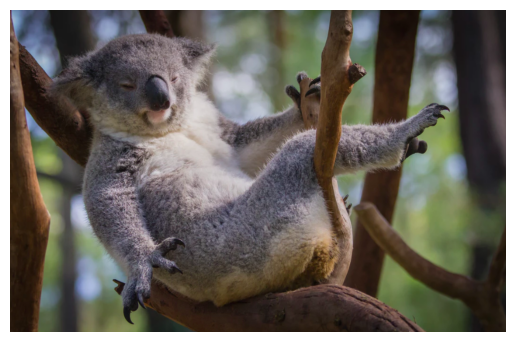

In [33]:
# For the example, I took a set of koalas
samples = glob.glob("assets/*.png")
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in samples]

plt.imshow(images[0])
plt.axis("off")
plt.show()

In [4]:
# pre-processing the image to pass it through the model; normalizing the input, and fitting
# it to required input size a multiple of the patch size.
def transform(img):
    img = cv2.resize(img, (patch_h * patch_size, patch_w * patch_size)) / 255
    img = (img - np.array([0.485, 0.456, 0.406]))/ np.array([0.229, 0.24, 0.225])
    img = img.transpose(2, 0, 1)
    return np.expand_dims(img, 0).astype(np.float32)

transformed_images = [transform(img) for img in images]

In [5]:
x = torch.tensor(np.concatenate(transformed_images)).cuda()

# Passing the input through the encoder
features_dict = encoder.forward_features(x)
features = features_dict["x_norm_patchtokens"].detach().cpu().numpy()
features.shape

(4, 2500, 1024)

In [6]:
patch_features = features.reshape(len(images) * patch_h * patch_w, -1)
patch_features.shape

(10000, 1024)

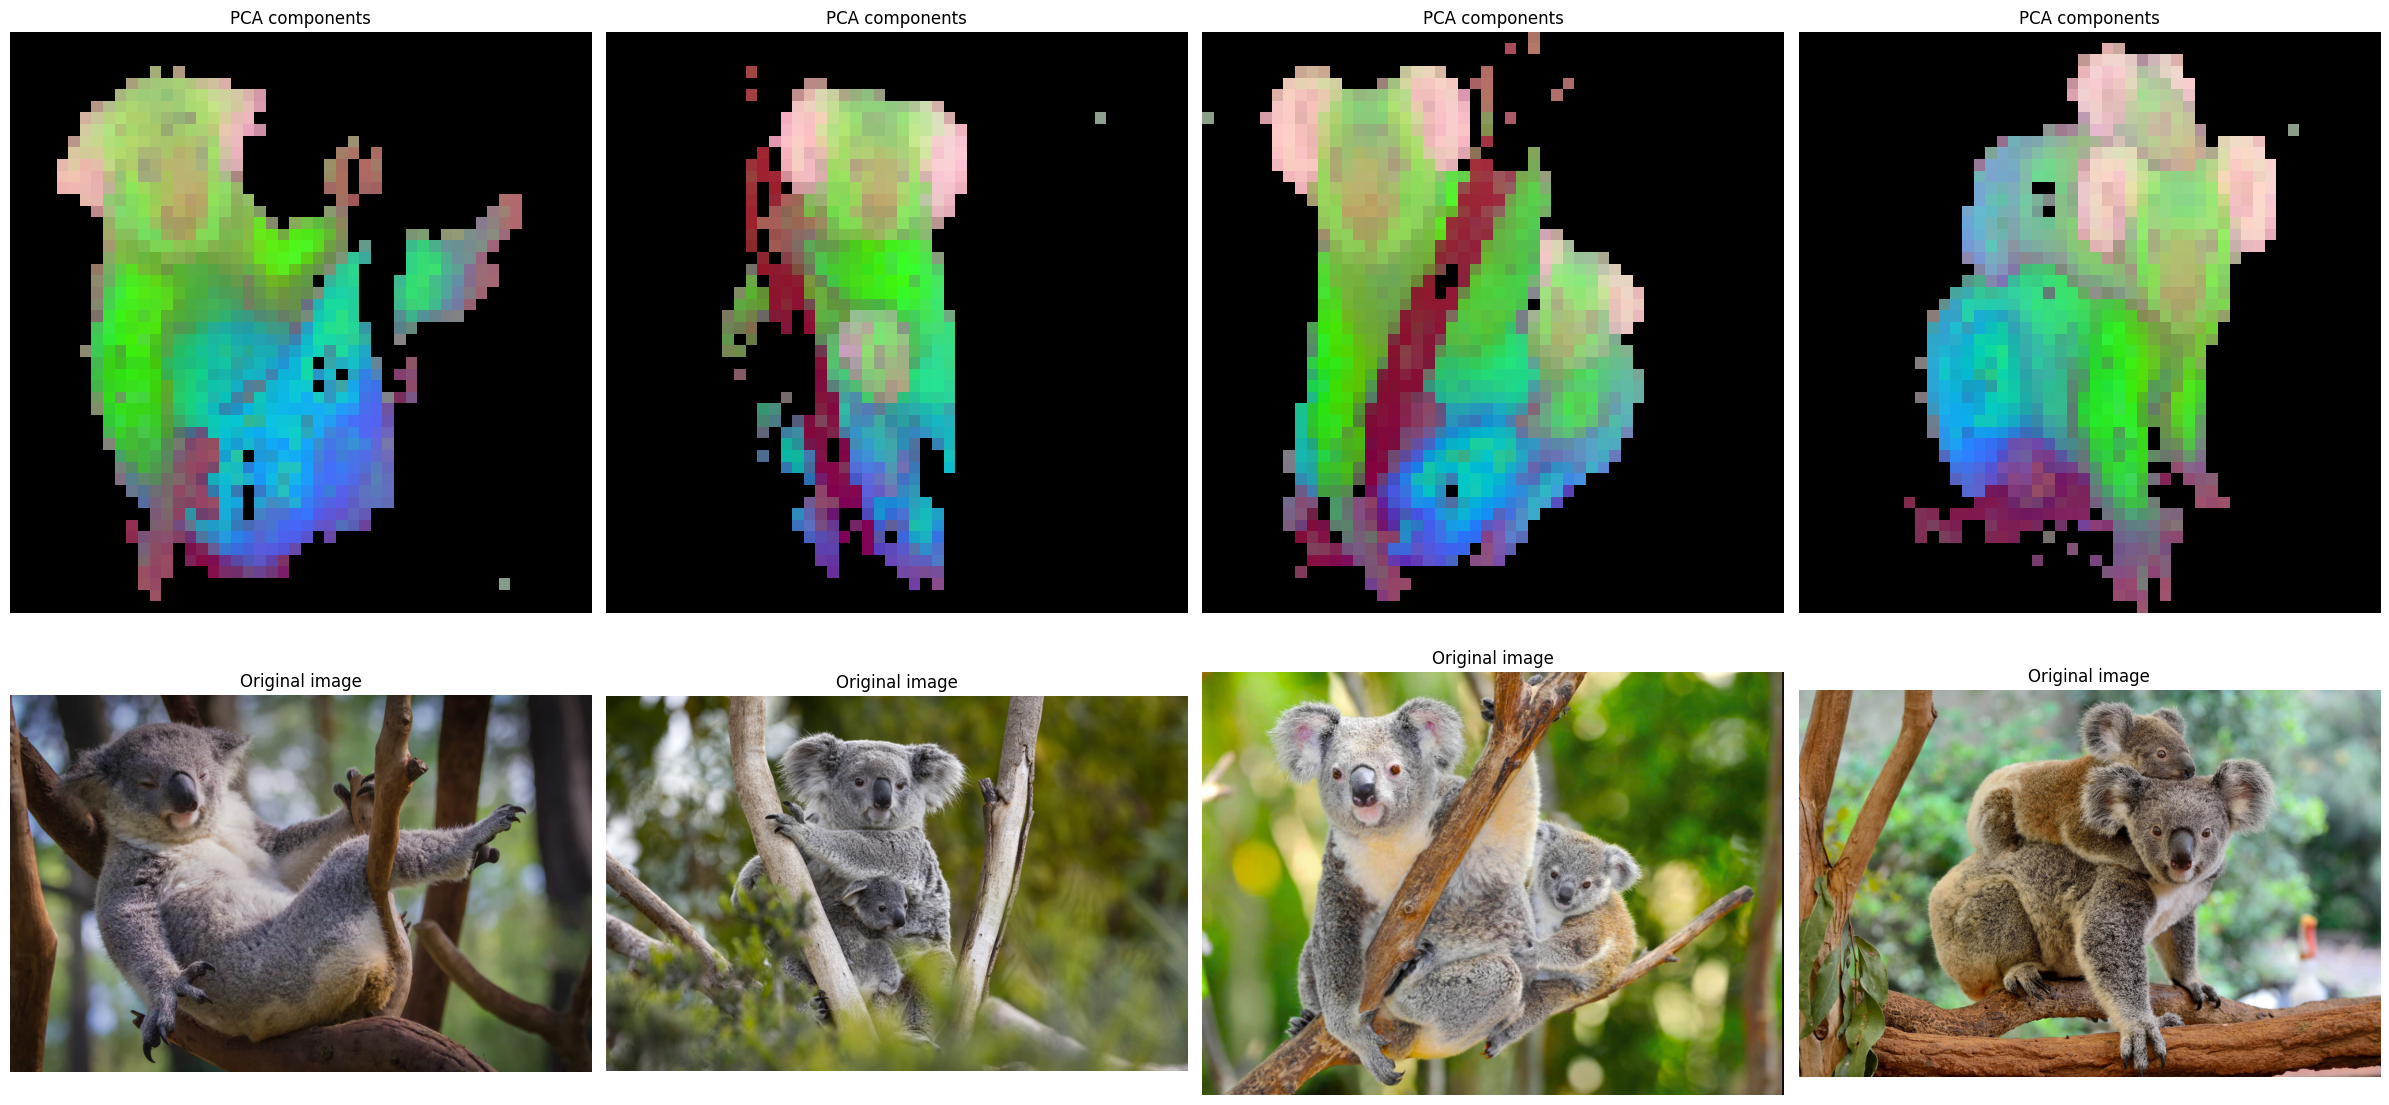

In [7]:
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)

# First fit to seperate background and foreground
pca.fit(patch_features)
pca_features = pca.transform(patch_features)

# MinMax Scaling
scaler.fit(pca_features)
pca_features = scaler.transform(pca_features)

pca_background = pca_features[:, 0] > background_threshold
pca_foreground = ~pca_background

# Second fit for the object
pca.fit(patch_features[pca_foreground])
pca_features_rem = pca.transform(patch_features[pca_foreground])

scaler.fit(pca_features_rem)
pca_features_rem = scaler.transform(pca_features_rem)

pca_features_rgb = np.zeros((len(images) * patch_h * patch_w, 3))
pca_features_rgb[pca_background] = 0
pca_features_rgb[pca_foreground] = pca_features_rem
pca_features_rgb = pca_features_rgb.reshape(len(images), patch_h, patch_w, 3)

fig, axes = plt.subplots(2, len(images), figsize=(6 * len(images), 12))
for i in range(len(images)):
    axes[0, i].imshow(pca_features_rgb[i])
    axes[0, i].set_title(f"PCA components")
    axes[0, i].axis("off")

    # Plot original images
    axes[1, i].imshow(images[i])
    axes[1, i].set_title(f"Original image")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Interesting here is that parts of the features which are semantically similar are also captured as such by the model, for example all the ears in the model have roughly the same colour in the PCA RGB component space.

## LoRA Finetuning Comparison

The idea of the Low-Rank Adaptation (LoRA) methodis very simple. Instead of finetuning the entire model, we introduce this small set of weights inbetween every block defined by $A_i \in \mathbb{R}^{r \times n}$ and $B_i \in \mathbb{R}^{n \times r}$ and multiplying these layers we will get $\Delta W_i = B_iA_i$. Moreover, we determine the size of these layers by setting a value for rank $r$, usually $r <\!\!< min(d, k)$, called rank as it determines the maximum size of our matrix $\Delta W_i$.

Then, during training we freeze the original ViT block and add our weight $\Delta W_i$, ViT_block $h_i$, becomes, 
$$
h_i = W_i x + \Delta W_i x.
$$
where $W_i$ are the original weights and we apply this to every block of the encoder, as seen in the first image in the notebook where we append a matrix $A$ and $B$ in between each ViT block. Here fire indicates the weights are updated during finetuning, and the ice crystal when the weights are kept frozen.

### Finetuning Image Segmentation on Pascal VOC
We finetune on the PASCAL Visual Image Classes (VOC) dataset containing a total of 21 classes, such as bicycles, birds, boats, bottles etc. The dataset is widely used as a simple benchmark dataset for image classification in computer vision.

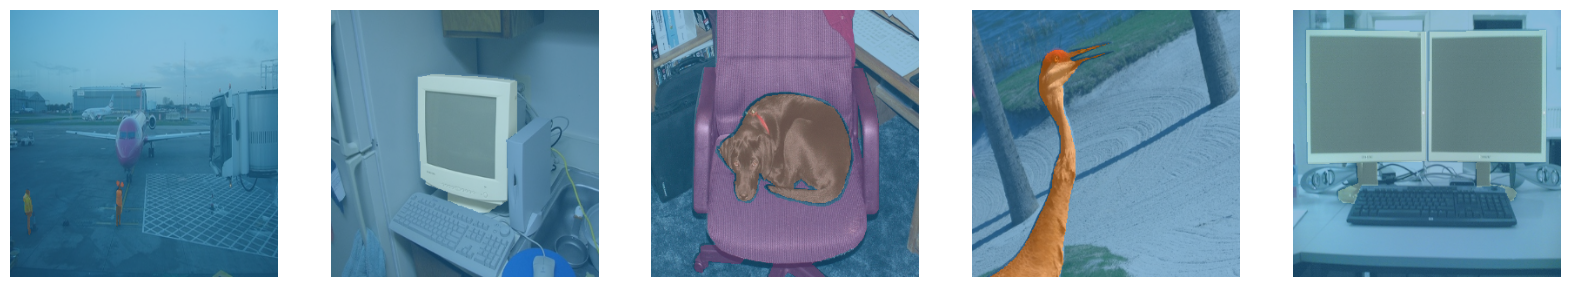

In [69]:
from torchmetrics.classification import JaccardIndex as IoU
from dino_finetune import DINOV2EncoderLoRA, get_dataloader, get_corruption_transforms, visualize_overlay

batch_size = 5
train_loader, val_loader = get_dataloader("voc", img_dim=(308, 308), batch_size=batch_size)
images, masks = next(iter(val_loader))

fig, axes = plt.subplots(1, batch_size, figsize=(20, 25))
colormap = plt.colormaps["tab20"]  # Defining some class colors
colors = np.array([colormap(i / 21) for i in range(21)])[:, :3] * 255

# Show the first batch
for i in range(batch_size):
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    mask = masks[i].detach().cpu().numpy()

    axes[i].imshow(0.5 * img + 0.5 * colors[mask] / 255.0)
    axes[i].axis("off")

plt.show()

Image segmentation is basically pixel-wise classification of the image, each pixel belongs to a single class. In the images above I overlay images from the validation set with its true image mask according to the dataset.


For the segmentation decoder, we use a $1 \times 1$ convolution to classify each pixel based on its channel values, determining the class for each pixel. This is one of the simplest decoders you can apply to the encoder outputs and still delivers decent segmentation performance due to the high-quality pre-trained encoder weights. However, one of the biggest limitations is that the output of the convolution has a very low resolution, which is then upscaled to the original image size to obtain a full-sized output.

In [73]:
# Setting the Encoder weights, initializing the 1x1 Conv Decoder, and initializing the LoRA weights
# Using the earlier defined encoder weights
dino_lora = DINOV2EncoderLoRA(
    encoder=encoder,
    r=3, # These are the same settings used in training
    emb_dim=1024, # The large ViT embedding dim
    img_dim=(308, 308), # For ease of use rescaling to a valid patch dimension 
    n_classes=21, # Number of classes in pascal VOC
    use_lora=True,
).cuda()

# Load the weights of an earlier training on the VOC dataset
dino_lora.load_parameters("output/base_voc.pt")
dino_lora.eval()

dino_lora

DINOV2EncoderLoRA(
  (encoder): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): LoRA(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (linear_a_q): Linear(in_features=1024, out_features=3, bias=False)
            (linear_b_q): Linear(in_features=3, out_features=1024, bias=False)
            (linear_a_v): Linear(in_features=1024, out_features=3, bias=False)
            (linear_b_v): Linear(in_features=3, out_features=1024, bias=False)
          )
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
   

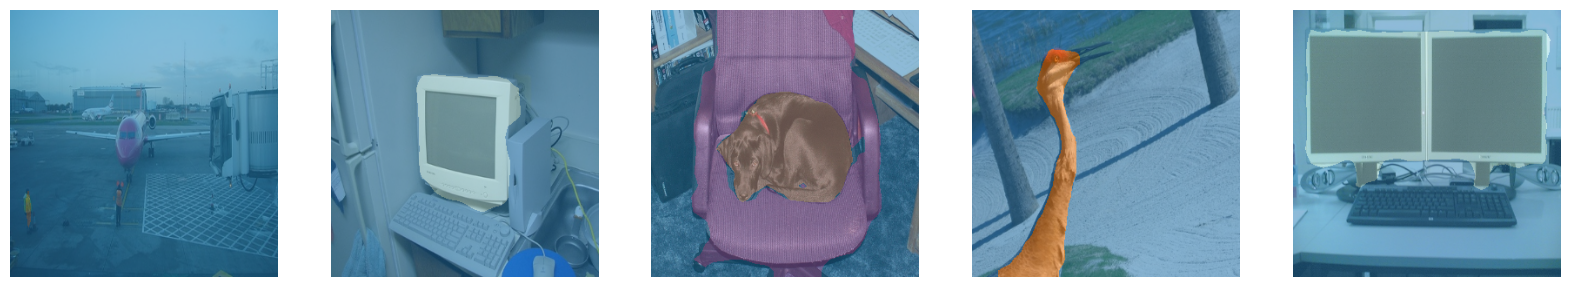

In [54]:
# Example outputs of the network with finetuned LoRA and decoder
logits = dino_lora(images.cuda().float())
y_hat = torch.argmax(torch.sigmoid(logits), dim=1)

fig, axes = plt.subplots(1, batch_size, figsize=(20, 25))
for i in range(batch_size):
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    mask = y_hat[i].detach().cpu().numpy()

    axes[i].imshow(0.5 * img + 0.5 * colors[mask] / 255.0)
    axes[i].axis("off")

plt.show()

Below I compare the baseline method in terms of validation IoU, that only finetunes the $1 \times 1$ convolution decoder versus the LoRA method, that finetunes the $1 \times 1$ convolution decoder plus 4 LoRA layers in between the ViT blocks. 

In [56]:
def load_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

# TODO: Rerun and add the metric.json's
# LoRA is about 7% better at the end of training compared to just the 1x1 conv

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 2)

lora_y = load_json("output/base_voc_metrics.json")["val_iou"]
plt.plot(range(lora_y), lora_y, "b-", label="Finetuning LoRA and a $1 \\times 1$ convolution decoder")
plt.scatter(range(lora_y), lora_y, c="blue")

baseline_y = load_json("output/base_voc_no_lora_metrics.json")["val_iou"]
plt.plot(range(baseline_y), baseline_y, "g-", label="Finetuning a $1\\times1$ convolution decoder")
plt.scatter(baseline_epoch, load_json("output/base_voc_no_lora_metrics.json")["val_iou"], c="green")

lora_y = load_json("output/base_voc_fpn_metrics.json")["val_iou"]
plt.plot(range(lora_y), lora_y, "r-", label="Finetuning LoRA and a FPN decoder")
plt.scatter(range(lora_y), lora_y, c="blue")

plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.title("Validation IoU Comparison between finetuning")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# TODO: Comparison with ADE20k

## Transfer and Adaptation

These types of pre-trained models with self-supervised learning show to good robustness to image corruptions, this phenomenom is also seen in the CLIP paper with good zero shot classification performance. For my test I tried to reproduce the idea of the ImageNet-C (Hendrycks & Dietterich, 2019) benchmark dataset, that is used to test how well the finetuned DINOv2 model handles image distortions like noise, blur, weather effects, and digital artifacts. Each distortion is applied at five levels of severity, from mild to severe, in the original paper it looks as follows.

<div style="text-align: center;">
<img src="assets/examples/corruption.png" alt="Different image distortions" width="70%"/>
</div>

I recreated the same image distortions in the Albumentations framework, choosing one corruption at a time and distorting the image at test time. However, there are a few augmentations that are not present in Albumentations which I skipped for now.

In [8]:
severity = 5

# The albumentations corruption augmentation policy
get_corruption_transforms((308, 308), severity=severity)

Compose([
  OneOf([
    GaussNoise(p=1.0, var_limit=(26, 38), per_channel=True, mean=0.0, noise_scale_factor=1.0),
    ISONoise(p=1.0, intensity=(0.9, 1.2), color_shift=(0.01, 0.05)),
    GaussianBlur(p=1.0, blur_limit=(5, 7), sigma_limit=(0, 0)),
    GlassBlur(p=1.0, sigma=1.5, max_delta=4, iterations=2, mode='fast'),
    Defocus(p=1.0, radius=(1, 10), alias_blur=(0, 0.5)),
    MotionBlur(p=1.0, blur_limit=(3, 13), allow_shifted=True),
    ZoomBlur(p=1.0, max_factor=(1, 1.31), step_factor=(0.01, 0.03)),
    RandomSnow(p=1.0, snow_point_range=(0.1, 0.55), brightness_coeff=2.5),
    ImageCompression(p=1.0, quality_range=(7, 7), compression_type=0),
    ElasticTransform(p=1.0, alpha=29.279999999999998, sigma=2.44, alpha_affine=4.88, interpolation=1, border_mode=4, value=None, mask_value=None, approximate=False, same_dxdy=False),
  ], p=1.0),
  Resize(p=1.0, height=308, width=308, interpolation=1),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=Tr

The corruption pipeline with severity level 5.

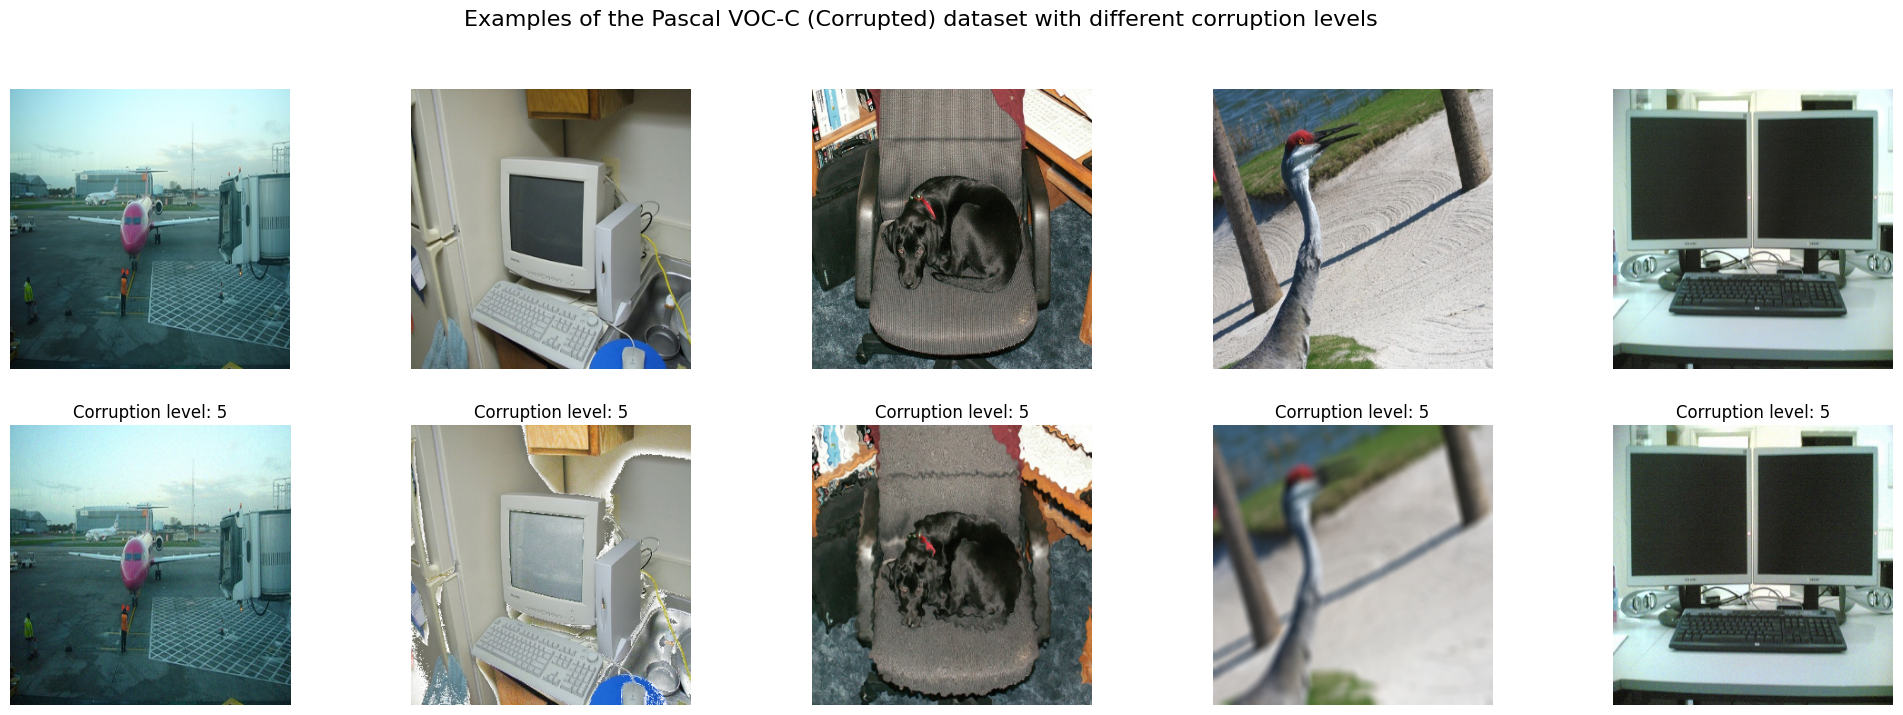

In [67]:
_, val_loader = get_dataloader("voc", img_dim=(308, 308), batch_size=batch_size)
_, corrupted_val_loader = get_dataloader("voc", img_dim=(308, 308), batch_size=batch_size, corruption_severity=severity)

# Get a single batch of both data loaders
images, _ = next(iter(val_loader))
c_images, _ = next(iter(corrupted_val_loader))

fig, axes = plt.subplots(2, batch_size, figsize=(25, 8))
fig.suptitle( "Examples of the Pascal VOC-C (Corrupted) dataset with different corruption levels", fontsize=16)

for i in range(batch_size):
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")

    img_c = c_images[i].cpu().numpy().transpose(1, 2, 0)
    axes[1, i].set_title(f"Corruption level: {severity}")
    axes[1, i].imshow(img_c)
    axes[1, i].axis("off")

plt.show()

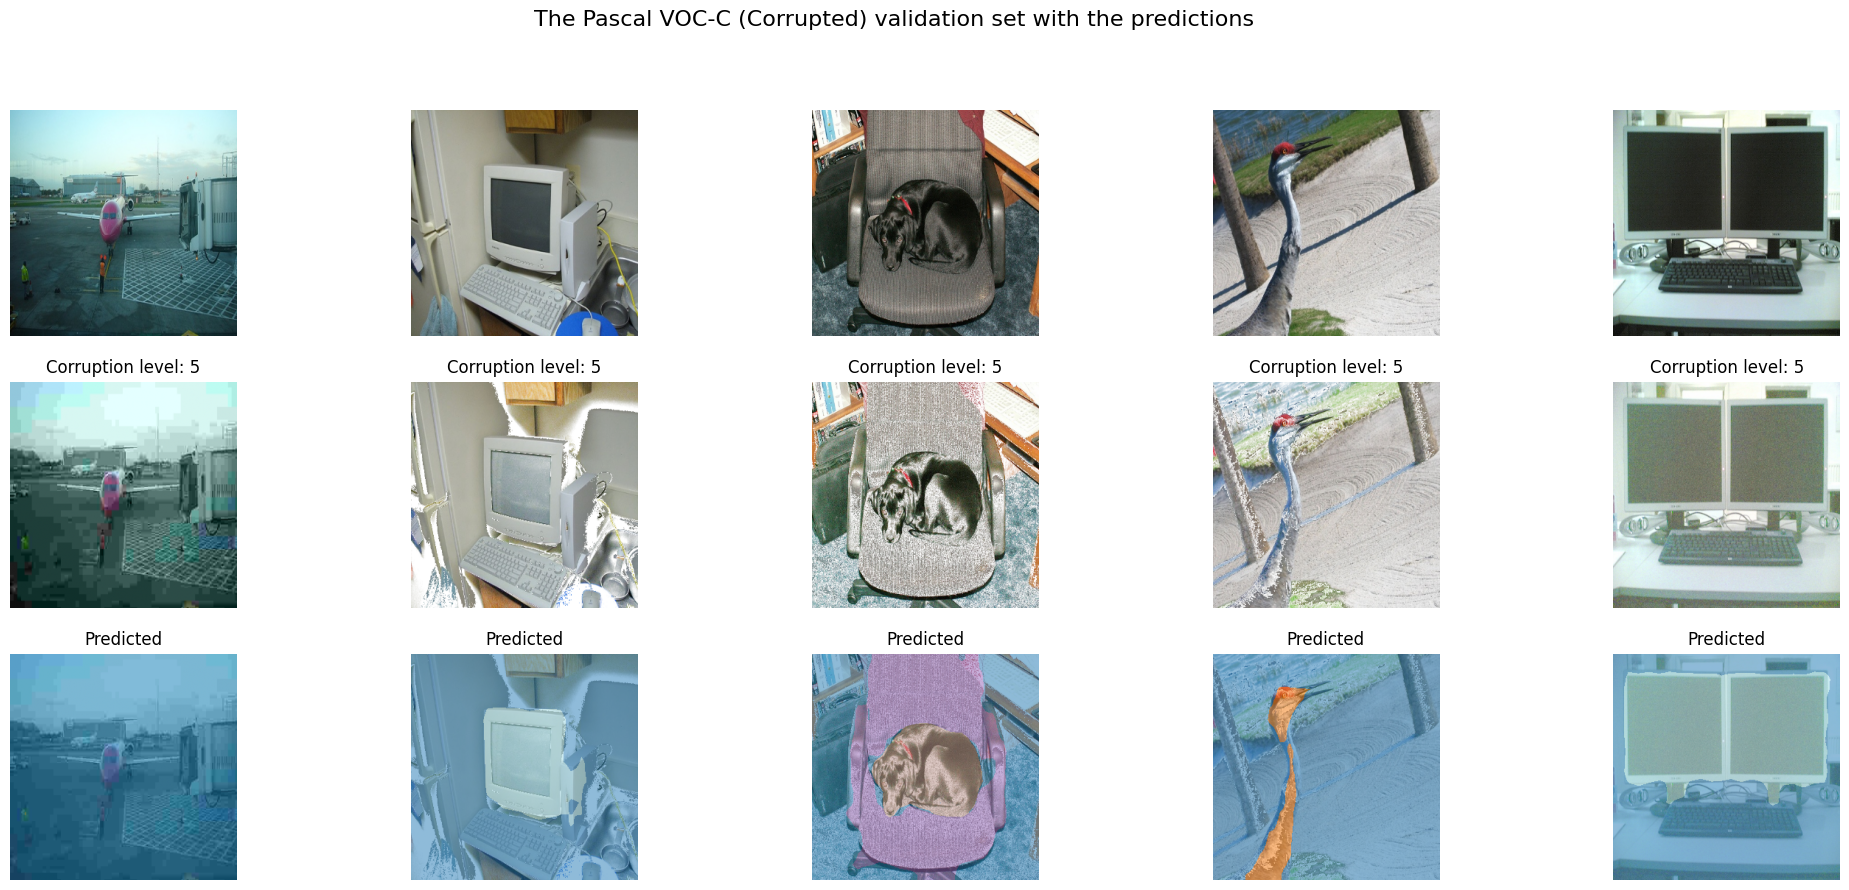

In [57]:
# Inference on the corrupted images
logits = dino_lora(c_images.cuda().float())
y_hat = torch.argmax(torch.sigmoid(logits), dim=1)

fig, axes = plt.subplots(3, batch_size, figsize=(25, 10))
fig.suptitle("The Pascal VOC-C (Corrupted) validation set with the predictions", fontsize=16)

for i in range(batch_size):
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    
    # The corrupted images
    img_c = c_images[i].cpu().numpy().transpose(1, 2, 0)
    axes[1, i].set_title(f"Corruption level: {severity}")
    axes[1, i].imshow(img_c)
    axes[1, i].axis("off")

    img_c = c_images[i].cpu().numpy().transpose(1, 2, 0)
    mask = y_hat[i].detach().cpu().numpy()
    axes[2, i].set_title(f"Predicted")
    axes[2, i].imshow(0.5 * img_c + 0.5 * colors[mask] / 255.0)
    axes[2, i].axis("off")

plt.show()

Now what does the addition of our methods do to the robustness of the network? I will evaluate the network with and without the corruption to the Pascal VOC dataset to see the impact on the metrics.

In [74]:
f_iou = IoU(task="multiclass", num_classes=21, average="micro", ignore_index=255).cuda()

# Using the validation loader to calculate the regular versus the corrupted error
def validate_epoch(dino_lora, val_loader, f_iou) -> float:
    val_iou = 0.0
    dino_lora.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.float().cuda()
            masks = masks.long().cuda()

            logits = dino_lora(images)
            y_hat = torch.sigmoid(logits)

            iou_score = f_iou(y_hat, masks)
            val_iou += iou_score.item()
    return val_iou / len(val_loader)


mIoU = validate_epoch(dino_lora, val_loader, f_iou)
corrupted_mIoU = validate_epoch(dino_lora, corrupted_val_loader, f_iou)

f"Regular validation mean IoU: {mIoU} versus corrupted level {severity} mean IoU: {corrupted_mIoU}"

'Regular validation mean IoU: 0.9530484017251701 versus corrupted level 5 mean IoU: 0.8914095104350979'

In [ ]:
# TODO: Comparison with ADE20k

## References
Oquab, M., Darcet, T., Moutakanni, T., Vo, H., Szafraniec, M., Khalidov, V., Fernandez, P., Haziza, D., Massa, F., El-Nouby, A., Assran, M., Ballas, N., Galuba, W., Howes, R., Huang, P.-Y., Li, S.-W., Misra, I., Rabbat, M., Sharma, V., … Bojanowski, P. (2024). DINOv2: Learning Robust Visual Features without Supervision (arXiv:2304.07193). arXiv. http://arxiv.org/abs/2304.07193

Darcet, T., Oquab, M., Mairal, J., & Bojanowski, P. (2024). Vision Transformers Need Registers (arXiv:2309.16588). arXiv. https://doi.org/10.48550/arXiv.2309.16588

Caron, M., Touvron, H., Misra, I., Jégou, H., Mairal, J., Bojanowski, P., & Joulin, A. (2021). Emerging Properties in Self-Supervised Vision Transformers (arXiv:2104.14294). arXiv. https://doi.org/10.48550/arXiv.2104.14294

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (arXiv:2010.11929). arXiv. https://doi.org/10.48550/arXiv.2010.11929

Hendrycks, D., & Dietterich, T. G. (2019). Benchmarking Neural Network Robustness to Common Corruptions and Surface Variations (arXiv:1807.01697). arXiv. https://doi.org/10.48550/arXiv.1807.01697